# Clasificación de números con CNNs (Convolutional Neural Networks)

In [11]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.12.1+cu102  Device: cuda


## Creación de los cargadores de datos.

In [12]:
batch_size = 30

transforms = transforms.Compose([
                                 transforms.Resize(32),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,)),
                                ])

train_dataset = datasets.MNIST('/tmp/data', 
                               train=True, 
                               download=True, 
                               transform=transforms)

validation_dataset = datasets.MNIST('/tmp/data', 
                                    train=False, 
                                    transform=transforms)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 3, 32, 32), i.e. it consists of a batch of images of size 3x32x32 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training icon.

In [13]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([30, 1, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([30]) type: torch.LongTensor


Mostramos los 10 primeros dígitos:

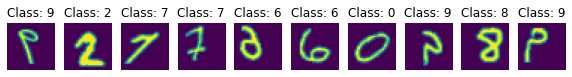

In [14]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i,:,:,:].numpy(), (1,2,0)))
    plt.title('Class: '+str(y_train[i].item()))

## Definición del modelo MLP.

El modelo se encuentra en: https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide/notebook



In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## anade tu modelo
        self.fc1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size= (5,5), stride=1)
        self.fc2 = nn.MaxPool2d(kernel_size= (2,2), stride=2)
        self.fc3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size= (5,5), stride=1)
        self.fc4 = nn.MaxPool2d(kernel_size= (2,2), stride=2)
        self.fc5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size= (5,5), stride=1)
        self.fc6 = nn.Linear(120, 84)#Tercera capa. Entrada de 5 a 50
        self.fc7 = nn.Linear(84, 10) #Ultima capa. Entrada de 50 a 784 

        
    def forward(self, x):

        x = F.tanh(self.fc1(x))  #tanh en la primera capa
        x = F.tanh(self.fc2(x))  #tanh en la segunda capa
        x = F.tanh(self.fc3(x))  #tanh en la tercera capa
        x = F.tanh(self.fc4(x))  #tanh en la cuarta capa
        x = F.tanh(self.fc5(x))  #tanh en la quinta capa
        x = x.view(-1, 120)
        x = F.relu(self.fc6(x))  #relu en la sexta capa
        x = self.fc7(x) 
        
        
        return x


## Creación del modelo, optimizador y función de pérdida.


In [16]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc6): Linear(in_features=120, out_features=84, bias=True)
  (fc7): Linear(in_features=84, out_features=10, bias=True)
)


## Learning

Definición del método de entrenamiento `train()` y del método de validación `validate()`. 

In [17]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [18]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


# Bucle de entrenamiento

Por cada epoch, vamos a entrenar y después a validar el modelo

In [19]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

/home/alfith/.local/lib/python3.10/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324857
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.349815
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.694797
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.620558
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.391266
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.340234
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.503586
Train Epoch: 1 [42000/60000 (70%)]	Loss: 0.204578
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.516990
Train Epoch: 1 [54000/60000 (90%)]	Loss: 0.470601

Validation set: Average loss: 0.3385, Accuracy: 8886/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.385438
Train Epoch: 2 [6000/60000 (10%)]	Loss: 0.222676
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.137202
Train Epoch: 2 [18000/60000 (30%)]	Loss: 0.316847
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.227049
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.140506
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.263408
Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.206888
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.17

Visualización del proceso de entrenamiento

* *Loss* diferencia entre la salida del modelo y la real.  Hay que minimizarla hasta 0, para ello usamos el optimizador.
* *Accuracy* es la precisión del modelo.

Text(0.5, 1.0, 'validation accuracy')

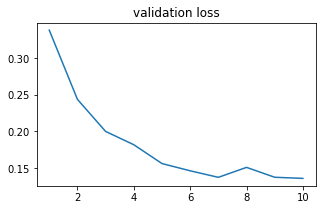

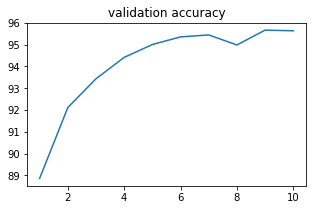

In [20]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')